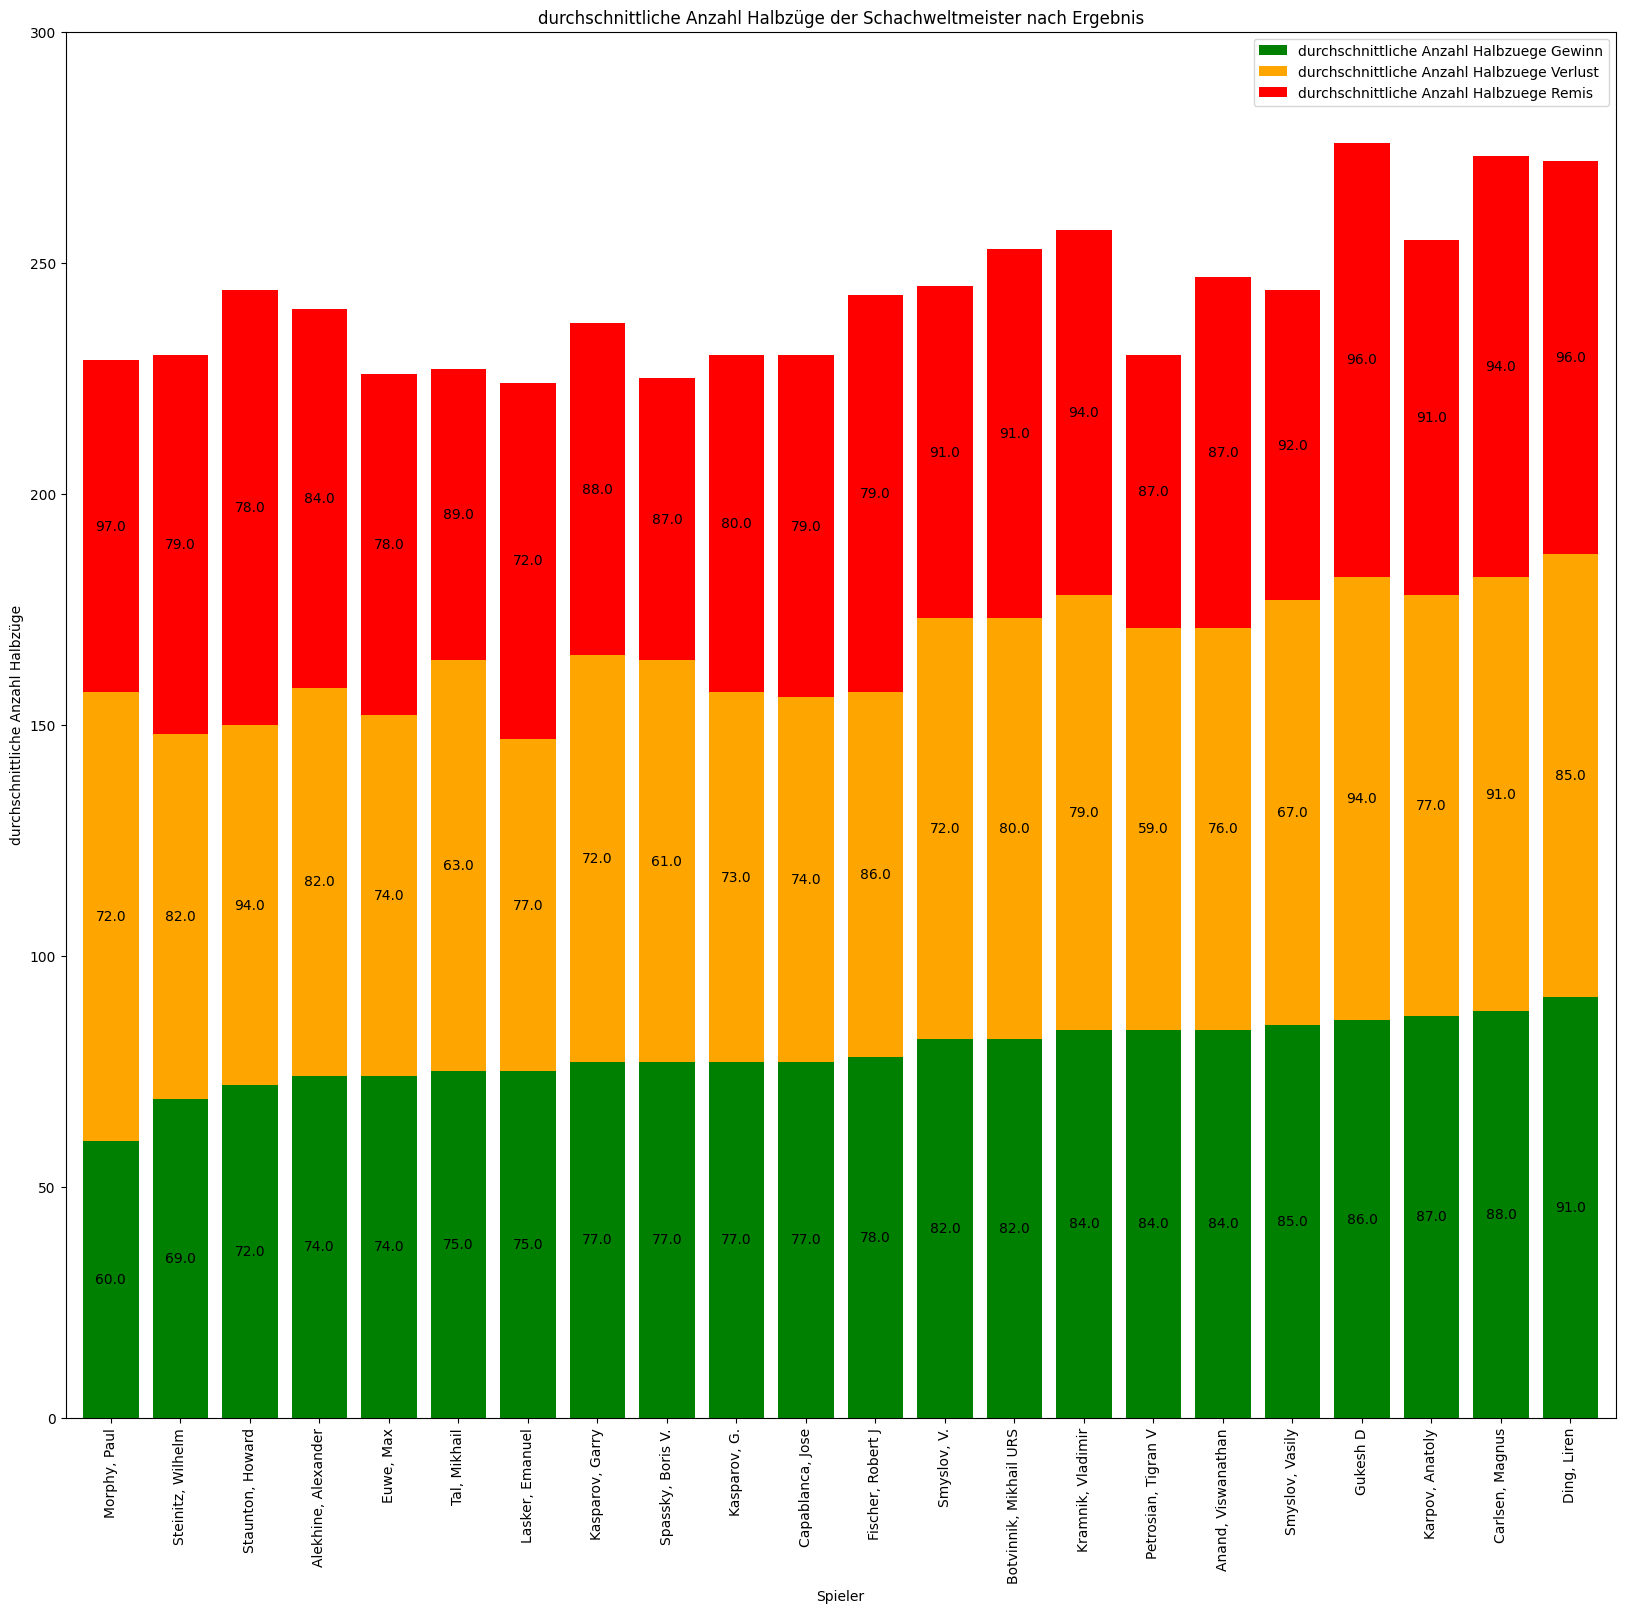

In [2]:
import sys
import os
import getpass
import mariadb
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from dotenv import load_dotenv

warnings.filterwarnings('ignore')
    
def connect(p_password):
    global conn
    global cursor
    
    # Database connection details
    db_config = {
        "user": "chess_user",
        "password": p_password,
        "host": "localhost",
        "database": "chess",
        "port": 3306,  # Standard port for MariaDB
    }
    # Establishing the connection
    conn = mariadb.connect(**db_config)
    # Disable autocommit
    conn.autocommit = False
    # Create a cursor to execute queries
    cursor = conn.cursor()

def disconnect():
    cursor.close()
    conn.close()

def get_data():
        df = pd.read_sql_query("""select
	t.spieler "Spieler",
	round(avg(case when t.result = 1 then t.anzahl_halbzuege else null end)) "durchschnittliche Anzahl Halbzuege Gewinn",
	round(avg(case when t.result = 2 then t.anzahl_halbzuege else null end)) "durchschnittliche Anzahl Halbzuege Verlust",
	round(avg(case when t.result = 3 then t.anzahl_halbzuege else null end)) "durchschnittliche Anzahl Halbzuege Remis"
from
	(
	select
		p.name Spieler,
		case
			when (p.id = g.white_player_id
			and g.result = 1)
			or (p.id = g.black_player_id
			and g.result = 2) then 1
			when (p.id = g.white_player_id
			and g.result = 2)
			or (p.id = g.black_player_id
			and g.result = 1) then 2
			else 3
		end result,
		(
		select
			count(*)
		from
			position
		where
			game_id = g.id) anzahl_halbzuege
		#(select avg(count(*)) from position po where po.game_id=g.id) countHalfMoves
	from
		player p
	join game g on
		(p.id = g.black_player_id
			or p.id = g.white_player_id )
	join position po on
		po.game_id = g.id
	where
		p.name in ('Staunton, Howard', 'Morphy, Paul', 'Steinitz, Wilhelm', 'Lasker, Emanuel', 'Capablanca, Jose', 'Alekhine, Alexander', 'Euwe, Max',
        'Botvinnik, Mikhail URS', 'Smyslov, Vasily', 'Smyslov, V.', 'Tal, Mikhail', 'Petrosian, Tigran V', 'Spassky, Boris V.', 'Fischer, Robert J', 'Karpov, Anatoly',
        'Kasparov, Garry', 'Kasparov, G.', 'Kramnik, Vladimir', 'Anand, Viswanathan', 'Carlsen, Magnus', 'Ding, Liren', 'Gukesh D')
	group by
		case
			when p.name in ('Kasparov, Garry', 'Kasparov, G.') then 'Kasparov, Garry'
			when p.name in ('Smyslov, Vasily', 'Smyslov, V.') then 'Smyslov, Vasily'
			else p.name
		end,
		g.id) t
group by
	t.spieler
order by
	2 ,
	3 desc""", conn)
        return(df)

def visualize_data(p_df): 
    color=['green', 'orange', 'red']
    ax=p_df.plot(x='Spieler', kind='bar', width=.8, stacked=True, figsize=(20,18), color=color, ylabel="durchschnittliche Anzahl Halbzüge", title="durchschnittliche Anzahl Halbzüge der Schachweltmeister nach Ergebnis")
    plt.bar_label(ax.containers[0], labels=p_df['durchschnittliche Anzahl Halbzuege Gewinn'], rotation = 0, label_type = "center")
    plt.bar_label(ax.containers[1], labels=p_df['durchschnittliche Anzahl Halbzuege Remis'], rotation = 0, label_type = "center")
    plt.bar_label(ax.containers[2], labels=p_df['durchschnittliche Anzahl Halbzuege Verlust'], rotation = 0, label_type = "center")
    plt.ylim([0,300])
    plt.show()

    
def main():
    # try to get passwd from .env file
    load_dotenv()
    passwd = os.getenv("passwd")
    
    # If password not provided, prompt securely
    if not passwd:
        try:
            passwd = getpass.getpass(prompt="Enter database password: ")
        except (KeyboardInterrupt, EOFError):
            print("\nPassword input cancelled.")
            sys.exit(1)

    # Validate password input
    if not passwd.strip():
        print("Error: Database password cannot be empty.")
        sys.exit(1)

    # connect to database
    try:
        connect(passwd)
        df = get_data()
        visualize_data(df)
        disconnect()
    except Exception as e:
        print(e)
        try:
            disconnect()
        except:
            pass
        sys.exit(1)


if __name__ == "__main__":
    main()
    
